# Car price prediction

Project for the Machine Learning course that aims to train and evaluate different models to predict the sale price of used cars.

## Setup 

In [87]:
import os
import time

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
plt.rc("axes", titleweight = "bold", titlesize = 18, titlepad = 10)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

import keras_tuner
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization

### Read the data

In [48]:
DATASET_FILENAME="car_prices.csv"
DATASET_DIR="./dataset"

car_data = pd.read_csv(os.path.join(DATASET_DIR, DATASET_FILENAME))

After downloading the data, I print the first 5 rows of the dataset to analyze it. 

In [49]:
car_data.head()

,manufacturer,model,year,transmission,mileage,fuelType,mpg,engineSize,price
0,Audi,A1,2017,Manual,15735,Petrol,55.4,1.4,12500
1,Audi,A6,2016,Automatic,36203,Diesel,64.2,2.0,16500
2,Audi,A1,2016,Manual,29946,Petrol,55.4,1.4,11000
3,Audi,A4,2017,Automatic,25952,Diesel,67.3,2.0,16800
4,Audi,A3,2019,Manual,1998,Petrol,49.6,1.0,17300


In [50]:
X = car_data.copy()
y = X.pop('price') # target column

I split data into training (65%), validation (15%) and test set (20%)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.12, random_state=42)

#Training Set
car_prices_data = pd.concat([X_train, y_train], axis = 1)

Now I start the data pre-processing, which will be done only on the training set.

## Data cleaning
I check if there are null or duplicate values.

In [52]:
car_prices_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29078 entries, 35519 to 19864
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   manufacturer  29078 non-null  object 
 1   model         29078 non-null  object 
 2   year          29078 non-null  int64  
 3   transmission  29078 non-null  object 
 4   mileage       29078 non-null  int64  
 5   fuelType      29078 non-null  object 
 6   mpg           29078 non-null  float64
 7   engineSize    29078 non-null  float64
 8   price         29078 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 2.2+ MB


In [53]:
car_prices_data.duplicated().sum()

317

There are 0 null values, but 317 duplicated values so I proceed with removing them.

In [54]:
car_prices_data = car_prices_data.drop_duplicates()
car_prices_data.duplicated().sum()

0

From the previous analysis the results are:
- 4 categorical attributes (manufacturer, model, transmission, fuelType)
- 5 numerical attributes (year, mileage, mpg, engineSize, price)

I declare them into the following two variables:

In [55]:
numerical = car_prices_data.loc[:, (car_prices_data.dtypes == int) | (car_prices_data.dtypes == float)].columns.tolist()
categorical = car_prices_data.loc[:, (car_prices_data.dtypes != int) & (car_prices_data.dtypes != float)].columns.tolist()

Now I want to observe a series of statistics of features and draw an histogram to represent the data distribution. Let’s start with the numerical features.  

In [56]:
car_prices_data.describe()

,year,mileage,mpg,engineSize,price
count,28761.000000,28761.000000,28761.000000,28761.000000,28761.000000
mean,2017.082786,23906.651368,55.745986,1.961987,21641.868885
std,2.245920,22506.207628,21.007529,0.601593,11651.848301
min,1970.000000,1.000000,1.100000,0.000000,650.000000
25%,2016.000000,6418.000000,45.600000,1.500000,13900.000000
50%,2017.000000,17814.000000,55.000000,2.000000,19575.000000
75%,2019.000000,34440.000000,64.200000,2.100000,26599.000000
max,2020.000000,259000.000000,470.800000,6.600000,149948.000000


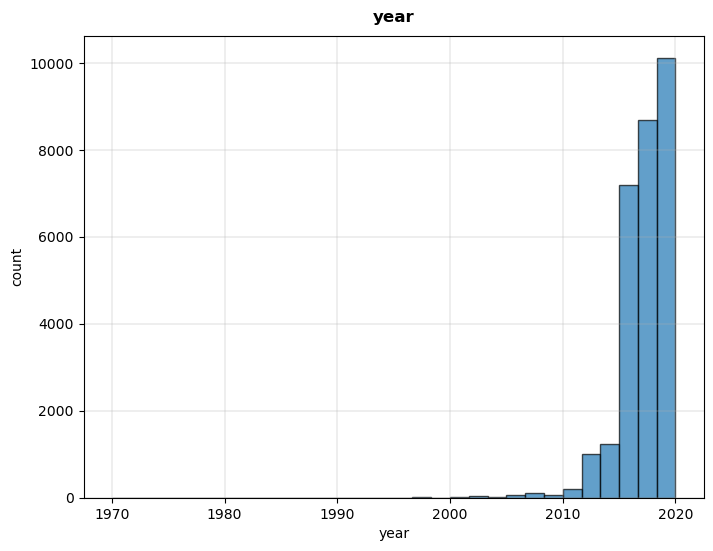

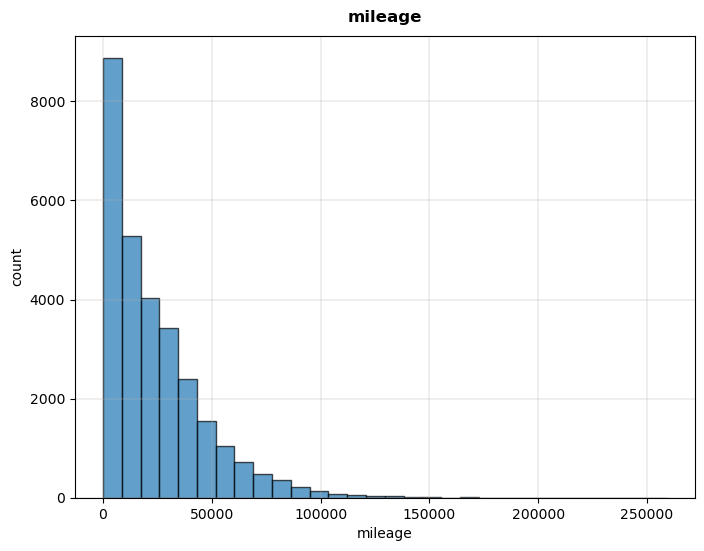

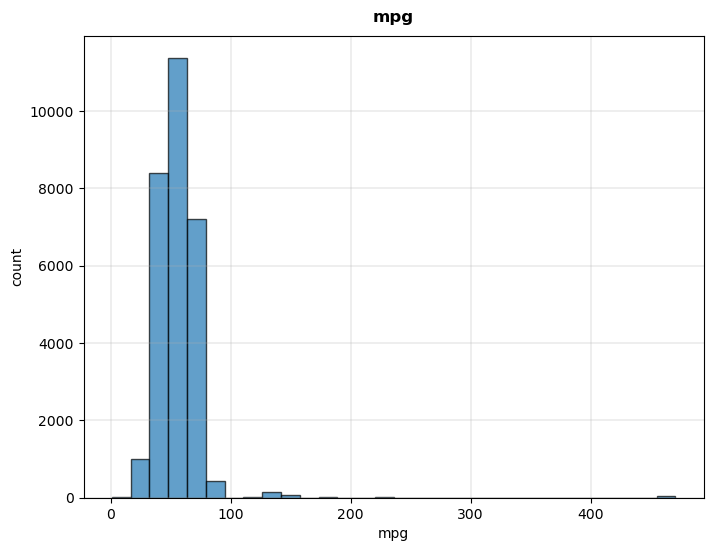

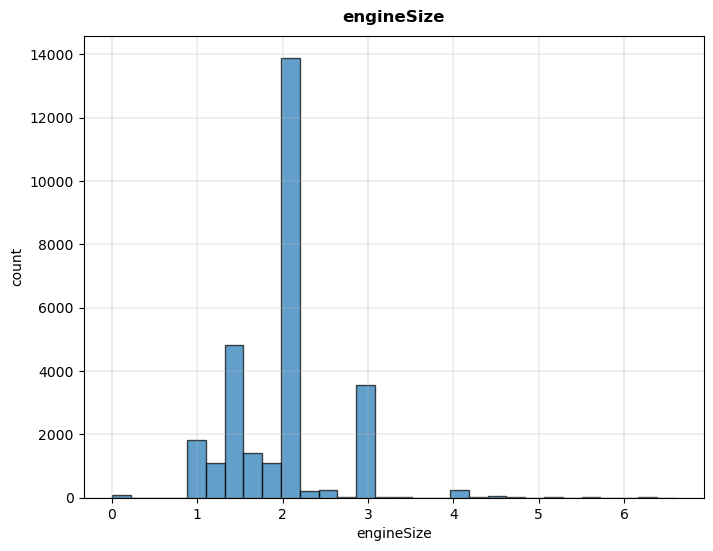

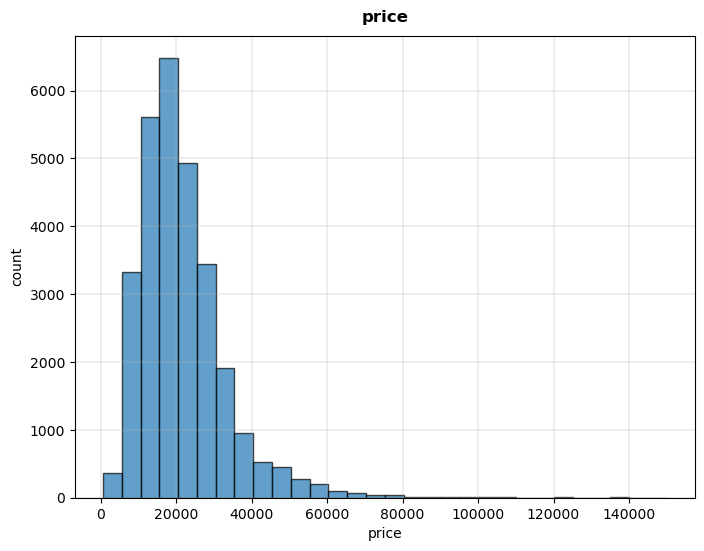

In [57]:
for feature in numerical:
    plt.figure(figsize  = (8,6))
    plt.hist(car_prices_data[feature], bins = 30, color = "tab:blue", edgecolor = "black", alpha = 0.7)

    plt.title(feature, fontsize = 12)
    plt.xlabel(feature, fontsize = 10)
    plt.ylabel("count", fontsize = 10)
    plt.grid(linewidth = 0.3)

    plt.show()

You may notice that some values appear few times and are very far from the average value. From the histograms I search for the minimum or maximum values that appear in a significant number of entries, and I check how many entries have value outside the range, so I don't have to consider them. 

In [58]:
(car_prices_data["year"] < 1998).value_counts()

year
False    28757
True         4
Name: count, dtype: int64

In [59]:
(car_prices_data["mileage"] > 200000).value_counts()

mileage
False    28758
True         3
Name: count, dtype: int64

In [60]:
(car_prices_data["mpg"] > 300).value_counts()

mpg
False    28728
True        33
Name: count, dtype: int64

In [61]:
(car_prices_data["price"] > 140000).value_counts()

price
False    28760
True         1
Name: count, dtype: int64

In addition, there are some entries that have 0.0 as engineSize value, which is not possible.   
I proceed with eliminating all the outliers described. 

In [62]:
car_prices_data = car_prices_data[car_prices_data["engineSize"] > 0.0]
car_prices_data = car_prices_data[car_prices_data["mpg"] <= 300]
car_prices_data = car_prices_data[car_prices_data["year"] >= 1999]
car_prices_data = car_prices_data[car_prices_data["mileage"] <= 200000]
car_prices_data = car_prices_data[car_prices_data["price"] <= 140000]

## Looking for correlation
I calculate the correlation between the numerical attributes and the price of the car, to verify that all are relevant in the prediction. 

In [63]:
corr_matrix = car_prices_data.corr(numeric_only=True)
corr_matrix["price"].sort_values(ascending=False)

price         1.000000
engineSize    0.601324
year          0.544662
mpg          -0.435701
mileage      -0.495347
Name: price, dtype: float64

There are no attributes with a value close to 0 (no correlation), so I keep all of them. 
I also want to observe the results in a scatter plot.

(0.0, 140000.0, 0.0, 7.0)

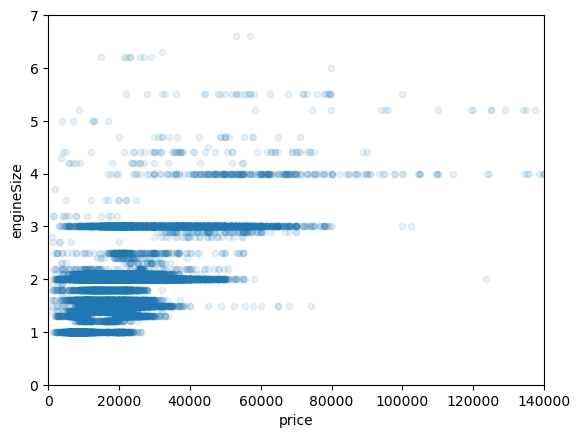

In [64]:
car_prices_data.plot(kind="scatter", x="price", y="engineSize",
             alpha=0.1)
plt.axis([0, 140000, 0, 7])

(0.0, 140000.0, 1999.0, 2020.0)

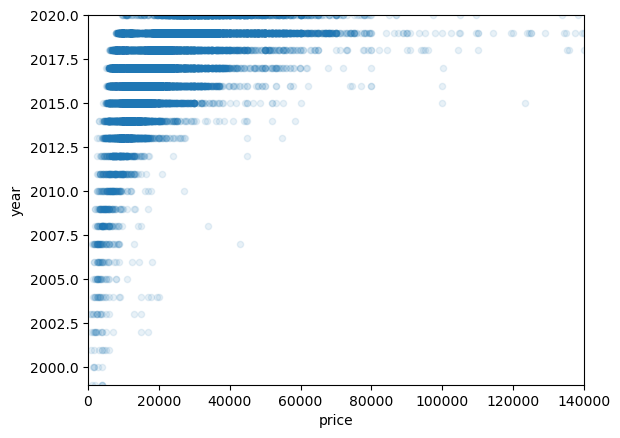

In [65]:
car_prices_data.plot(kind="scatter", x="price", y="year",
             alpha=0.1)
plt.axis([0, 140000, 1999, 2020])

(0.0, 140000.0, 0.0, 300.0)

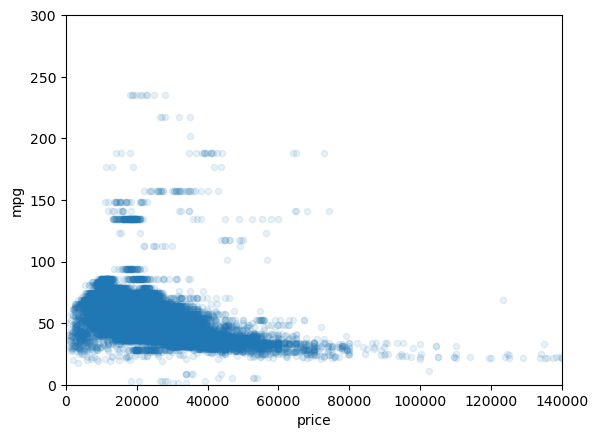

In [66]:
car_prices_data.plot(kind="scatter", x="price", y="mpg",
             alpha=0.1)
plt.axis([0, 140000, 0, 300])

(0.0, 140000.0, 0.0, 200000.0)

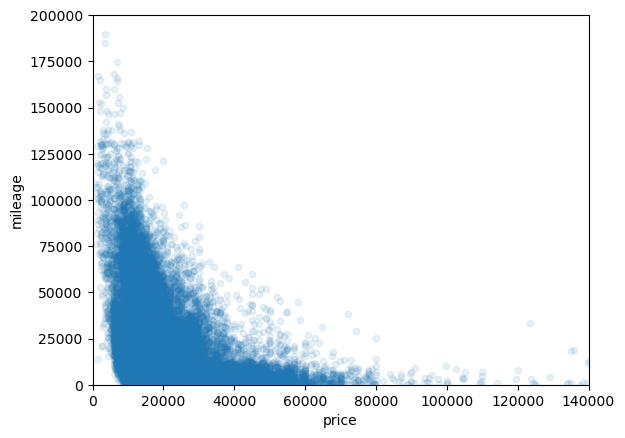

In [67]:
car_prices_data.plot(kind="scatter", x="price", y="mileage",
             alpha=0.1)
plt.axis([0, 140000, 0, 200000])

I didn't use a correlation matrix or a scatter matrix because I was interested in correlating each attribute to the car price. If I had decided to delete an attribute, I would have evaluated its impact against all other attributes. 

Now let's analyze the categorical features by visualizing the data in a bar plot.

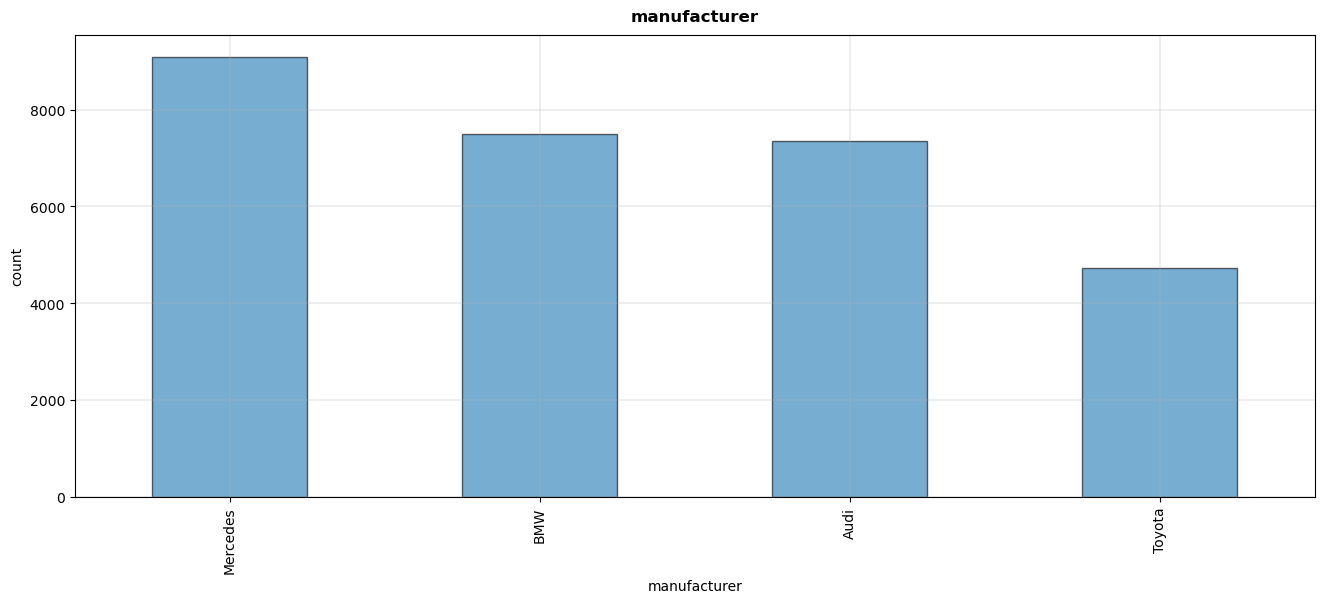

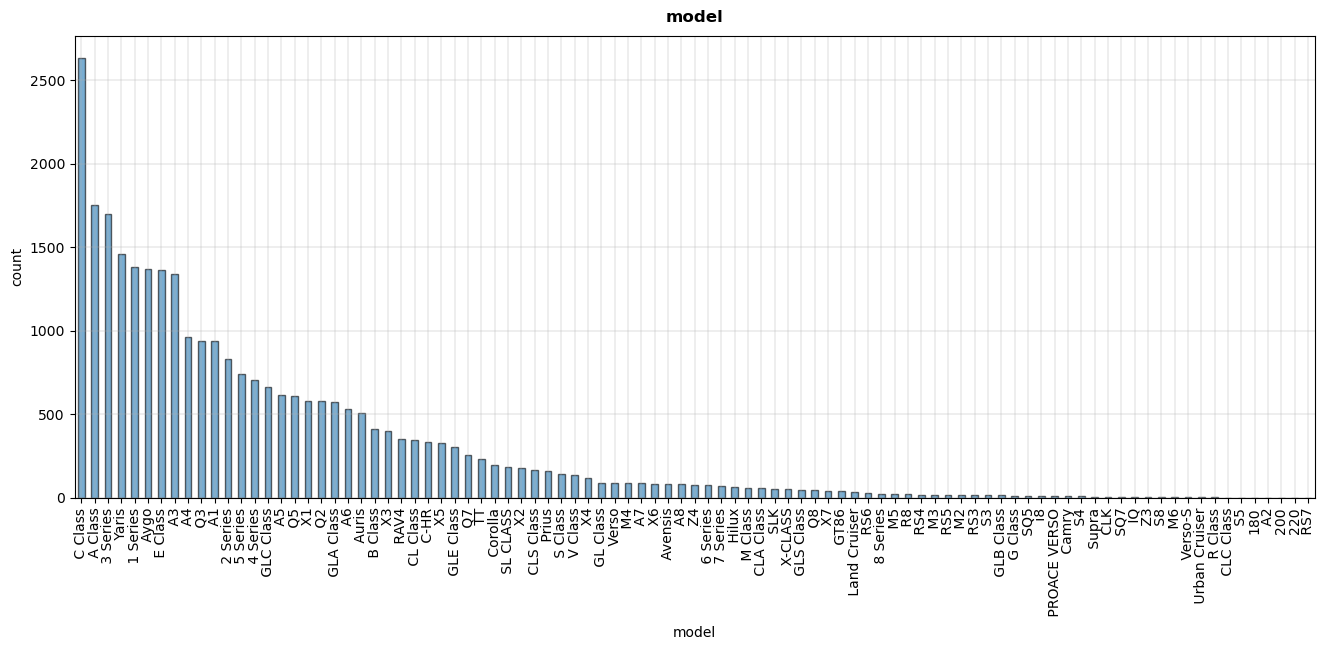

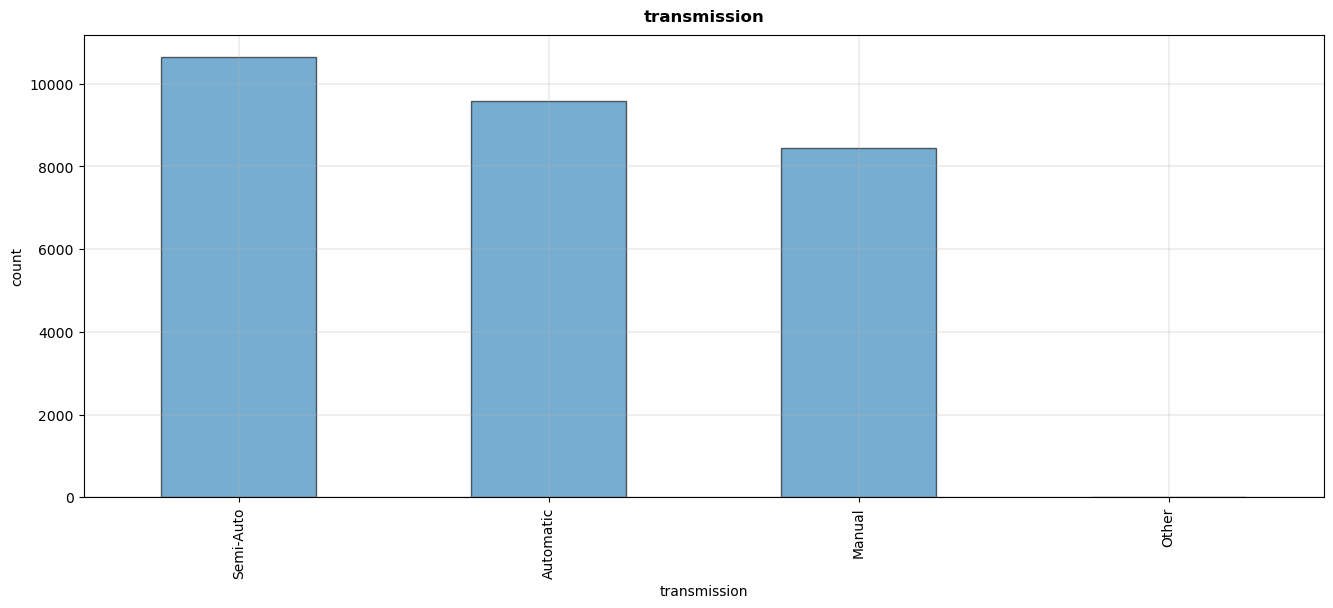

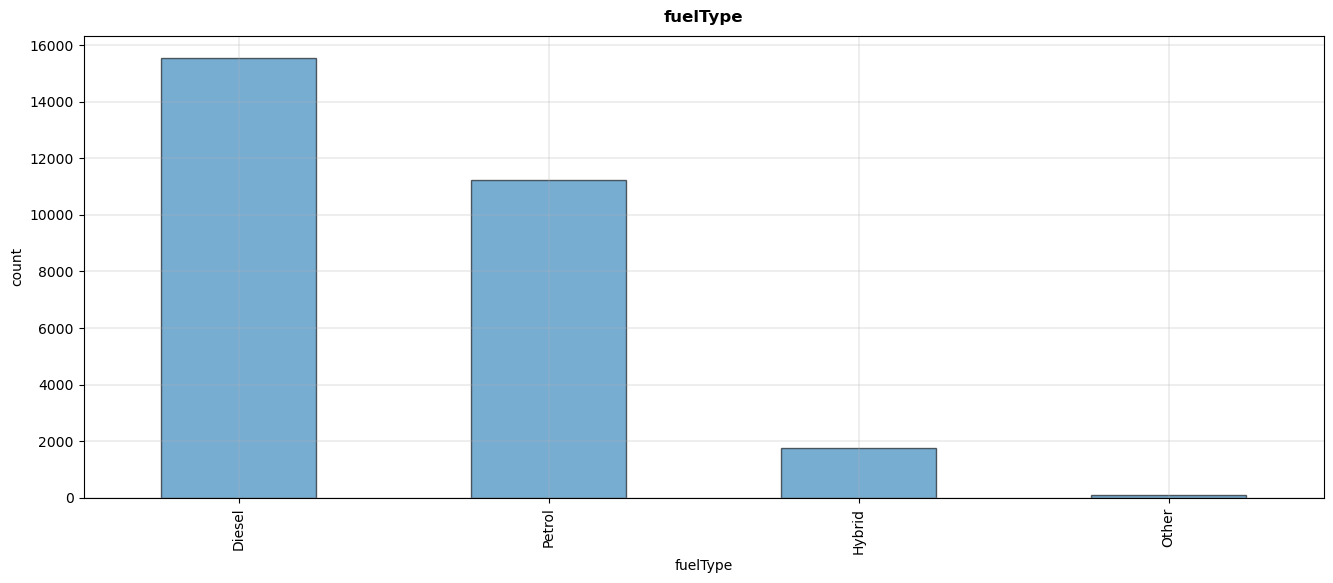

In [68]:
for feature in categorical:
    plt.figure(figsize=(16,6))
    car_prices_data[feature].value_counts().plot(kind='bar', color="tab:blue", edgecolor="black", alpha=0.6)
    
    plt.title(feature, fontsize=12)
    plt.xlabel(feature, fontsize=10)
    plt.ylabel("count", fontsize=10)
    plt.grid(linewidth=0.3)
    
    plt.show()

### Categorical variable encoding
Many algorithms do not support categorical attributes, which must therefore be transformed into a numerical format through categorical variable encoding. This process provides two alternatives: one hot encoding and dummy encoding. 
I choose to use one hot encoding.

In [69]:
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)

### Numerical features standardization 
I apply a standardization of data by removing the mean and scaling to unit variance. StandardScaler is sensitive to outliers, but I removed them before, so it won't be a problem. 

In [70]:
transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # default fill value=0
    StandardScaler(),
)

These transformations must be applied to the entire dataset, not only on the training set.

In [71]:
X_train = car_prices_data.copy()
y_train = X_train.pop("price")

numerical_features = ["year","mileage","engineSize","mpg"]

preprocessor = make_column_transformer(
    (transformer_num, numerical_features),
    (transformer_cat, categorical),
)

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

## Select and train a model
I decide to make the prediction on the validation set, using the following models:
- Linear Regression
- Decision Tree
- Random Forest
- K-Nearest Neighbour
- Neural Network

I evaluate the error according to two metrics: Root Mean Squared Error and Mean Absolute Error.

### Linear regression

In [72]:
# Create linear regression object
lin_reg = LinearRegression()

# Train the model using the training set
lin_reg.fit(X_train, y_train)

# Prediction using the validation set
lin_pred = lin_reg.predict(X_val)

# Root Mean Squared Error 
lin_mse = mean_squared_error(y_val, lin_pred)
lin_rmse = np.sqrt(lin_mse)
print("RMSE:",lin_rmse)
# Mean Absolute Error
lin_mae = mean_absolute_error(y_val, lin_pred)
print("MAE:",lin_mae)

RMSE: 4896.408969510333
MAE: 3054.4360155665895


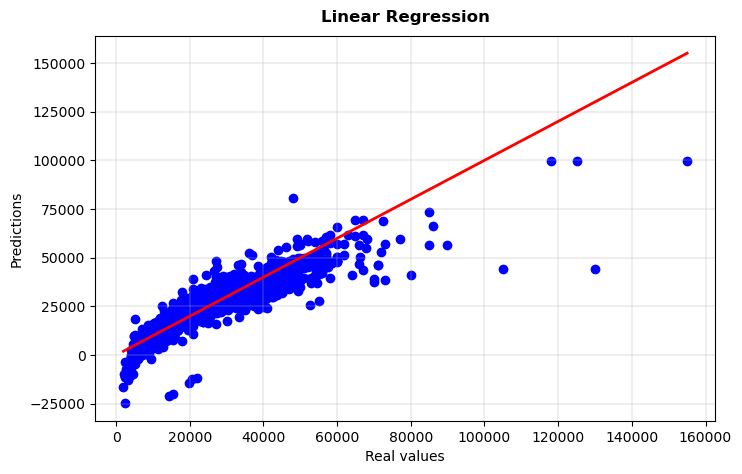

In [73]:
# Plot outputs
plt.figure(figsize = (8, 5))
plt.scatter(y_val, lin_pred, color="blue")
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linewidth=2)
plt.title("Linear Regression", fontsize=12)
plt.xlabel("Real values", fontsize=10)
plt.ylabel("Predictions", fontsize=10)
plt.grid(linewidth=0.3)
plt.show()

### Decision Tree

In [74]:
tree_reg = DecisionTreeRegressor(random_state=42)

# Train the model using the training set
tree_reg.fit(X_train, y_train)

# Prediction using the training set
tree_pred = tree_reg.predict(X_val)

# Root Mean Squared Error 
tree_mse = mean_squared_error(y_val, tree_pred)
tree_rmse = np.sqrt(tree_mse)
print("RMSE:",tree_rmse)
# Mean Absolute Error
tree_mae = mean_absolute_error(y_val, tree_pred)
print("MAE:",tree_mae)

RMSE: 3236.832278502468
MAE: 1800.6005448094515


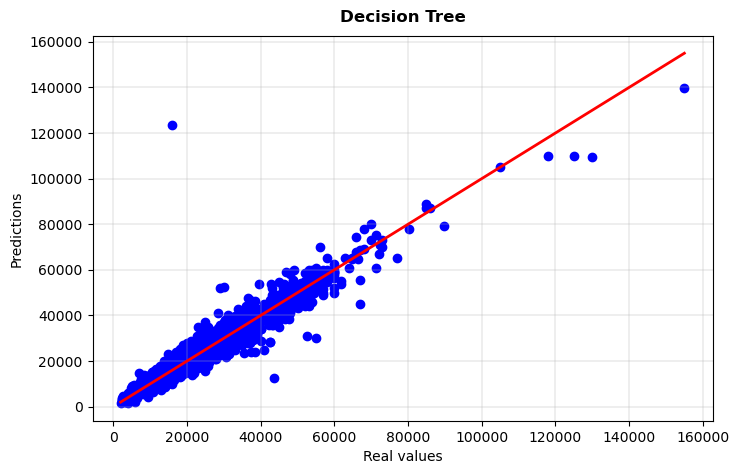

In [75]:
# Plot outputs
plt.figure(figsize = (8, 5))
plt.scatter(y_val, tree_pred, color="blue")
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linewidth=2)
plt.title("Decision Tree", fontsize=12)
plt.xlabel("Real values", fontsize=10)
plt.ylabel("Predictions", fontsize=10)
plt.grid(linewidth=0.3)
plt.show()

### Random Forest

I want to search the best hyperparameters of the model. I use a Random Search instead of a Grid Search because I want to optimize 5 hyperparameters with a large number of possible choices, leading to 11x9x11x5x4 = 21780 different combinations, not feasible with a Grid Search. 

In [76]:
#random_grid = {'n_estimators': [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
              # 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9],
              # 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
              #'min_samples_split': [2, 4, 6, 8, 10],
              # 'min_samples_leaf': [1, 2, 3, 4]}

#rnd_rf = RandomForestRegressor(random_state=42)
#rnd_search = RandomizedSearchCV(rnd_rf, param_distributions=random_grid, n_iter=100, cv=3, scoring='neg_mean_squared_error', random_state=42, verbose=2)
#rnd_search.fit(X_train, y_train)

In [77]:
#rnd_search.best_params_

The Random Search selected as the best combination: 

n_estimators: 200, min_samples_split: 4, min_samples_leaf: 1, max_features: 9, max_depth: None

In [78]:
rf_reg = RandomForestRegressor(n_estimators=200, min_samples_split=4, min_samples_leaf=1, max_features=9, max_depth=None)
rf_reg.fit(X_train, y_train)
rf_pred = rf_reg.predict(X_val)

# Root Mean Squared Error 
rf_mse = mean_squared_error(y_val, rf_pred)
rf_rmse = np.sqrt(rf_mse)
print("RMSE:",rf_rmse)
# Mean Absolute Error
rf_mae = mean_absolute_error(y_val, rf_pred)
print("MAE:",rf_mae)

RMSE: 2453.3541294847823
MAE: 1448.4459037352406


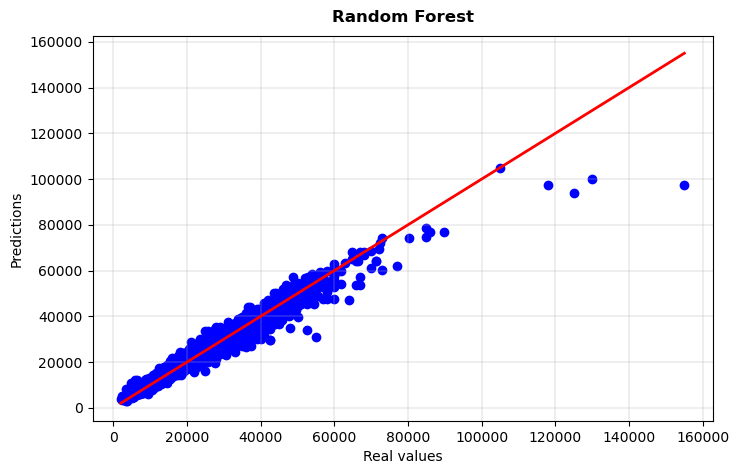

In [79]:
# Plot outputs
plt.figure(figsize = (8, 5))
plt.scatter(y_val, rf_pred, color="blue")
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linewidth=2)
plt.title("Random Forest", fontsize=12)
plt.xlabel("Real values", fontsize=10)
plt.ylabel("Predictions", fontsize=10)
plt.grid(linewidth=0.3)
plt.show()

### K-Nearest Neighbour

Now I want to optimize only the hyperparameter K, trying with a small number of values. So I use a Grid Search, which in this case is not too expensive. 

In [80]:
#param_grid = {"n_neighbors": [3, 5, 7, 9]}

#grid_knn = KNeighborsRegressor()

#grid_search = GridSearchCV(estimator = grid_knn, param_grid = param_grid, scoring = "neg_mean_squared_error", cv = 5, verbose = 2)
#grid_search.fit(X_train, y_train)

In [81]:
#best_params = grid_search.best_params_
#print("Best K: ", best_params["n_neighbors"])

The Grid Search selected as the best K: 3

In [82]:
knn_reg = KNeighborsRegressor(n_neighbors = 3)
knn_reg.fit(X_train, y_train)
knn_pred = knn_reg.predict(X_val)

# Root Mean Squared Error 
knn_mse = mean_squared_error(y_val, knn_pred)
knn_rmse = np.sqrt(knn_mse)
print("RMSE:",knn_rmse)
# Mean Absolute Error
knn_mae = mean_absolute_error(y_val, knn_pred)
print("MAE:",knn_mae)

RMSE: 2665.2935602610505
MAE: 1615.8749369641957


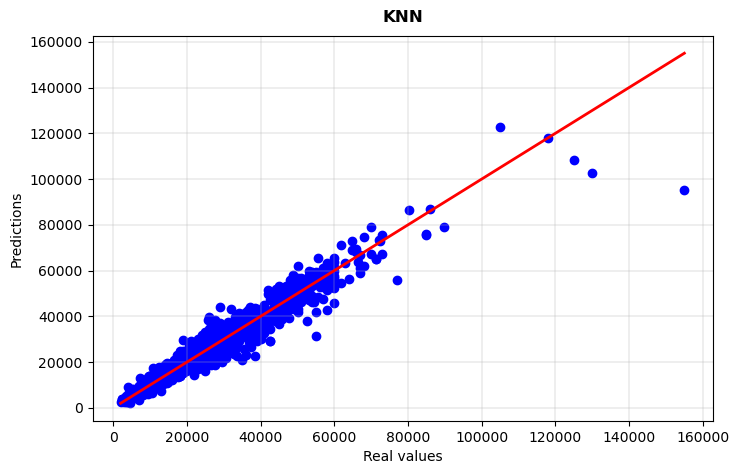

In [83]:
# Plot outputs
plt.figure(figsize = (8, 5))
plt.scatter(y_val, knn_pred, color="blue")
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linewidth=2)
plt.title("KNN", fontsize=12)
plt.xlabel("Real values", fontsize=10)
plt.ylabel("Predictions", fontsize=10)
plt.grid(linewidth=0.3)
plt.show()

### Neural Network

Before training a neural network, I determine the best parameters to create it, considering:
- Dropout Rate
- Number of units in the first layer
- Number of hidden layers
- Number of dropout layers
- Number of units in each hidden layer
- Number of epochs using early stopping

In [84]:
def build_model(hp):
    model = Sequential()

    input_shape = X_train.shape[1]

    dropoutRate = hp.Float("drRate", min_value=0.1, max_value=0.3, step=0.1)
   
    #Input Layer
    model.add(Dense(
            units=hp.Int("units", min_value=50, max_value=150, step=15),
            activation="relu",
            input_shape = (input_shape,))
    )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=dropoutRate))

    #Hidden Layers
    for i in range(hp.Int("hidden_layers", 1, 2)):
        model.add(Dense(
                units=hp.Int(f"units_{i}", min_value=10, max_value=100, step=20),
                activation="relu")
        )
        if hp.Boolean(f"dropout_{i}"):
            model.add(layers.Dropout(rate=dropoutRate))

    #Output Layer
    model.add(Dense(
            units=1,
            activation="linear")
    )
    
    model.compile(
        optimizer="adam",
        loss="mean_squared_error",
        metrics=["mean_absolute_error"]
    )

    return model

build_model(keras_tuner.HyperParameters())

In [88]:
# Transform the data in array
X_train_dense = X_train.toarray()
X_val_dense = X_val.toarray()

tuner = keras_tuner.Hyperband(
    hypermodel=build_model,
    objective="val_mean_absolute_error",
    overwrite=False,
    max_epochs=100,
    directory="kerastuner",
    project_name="ml_project",
)

tuner.search_space_summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tuner.search(X_train_dense, y_train, validation_data=(X_val_dense, y_val), callbacks=[early_stopping])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from kerastuner/ml_project/tuner0.json
Search space summary
Default search space size: 8
drRate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 150, 'step': 15, 'sampling': 'linear'}
dropout (Boolean)
{'default': False, 'conditions': []}
hidden_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 20, 'sampling': 'linear'}
dropout_0 (Boolean)
{'default': False, 'conditions': []}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 20, 'sampling': 'linear'}
dropout_1 (Boolean)
{'default': False, 'conditions': []}


In [113]:
print("Best hyperparameters:")
print(f" - drRate: {best_hps.get('drRate')}")
print(f" - epochs: {best_hps.get('tuner/epochs')}")
print("Input layer")
print(f" - units: {best_hps.get('units')}")
print(f" - dropout: {best_hps.get('dropout')}")
print(f" - hidden_layers: {best_hps.get('hidden_layers')}")
for i in range(best_hps.get('hidden_layers')):
    print(f"Hidden layer {i+1}")
    print(f" - units: {best_hps.get(f'units_{i}')}")
    print(f" - dropout: {best_hps.get(f'dropout_{i}')}")

Best hyperparameters:
 - drRate: 0.2
 - epochs: 100
Input layer
 - units: 125
 - dropout: False
 - hidden_layers: 2
Hidden layer 1
 - units: 50
 - dropout: False
Hidden layer 2
 - units: 30
 - dropout: False


Based on the hyperparameters returned by the tuner I build a model of neural network and train it without using the early stopping, but specifying the number of epochs established previously. 

In [91]:
def final_model():
    model = tf.keras.Sequential()

    model.add(Dense(units=125, activation="relu", input_shape = (X_train.shape[1],)))
    model.add(Dense(units=50,activation="relu"))
    model.add(Dense(units=30,activation="relu"))
    model.add(Dense(units=1, activation="linear"))
    
        
    model.compile(
        optimizer="adam",
        loss="mean_squared_error",
        metrics=["mean_absolute_error"]
    )
     
    return model

nn_reg = final_model()
nn_reg.fit(X_train_dense, y_train, epochs=100, validation_data=(X_val_dense, y_val), verbose = 0)
nn_pred = nn_reg.predict(X_val_dense)

# Root Mean Squared Error 
nn_mse = mean_squared_error(y_val, nn_pred)
nn_rmse = np.sqrt(nn_mse)
print("RMSE:",nn_rmse)
# Mean Absolute Error
nn_mae = mean_absolute_error(y_val, nn_pred)
print("MAE:",nn_mae)

124/124 [==============================] - 0s 505us/step
RMSE: 2460.9972345382653
MAE: 1655.1394822298128


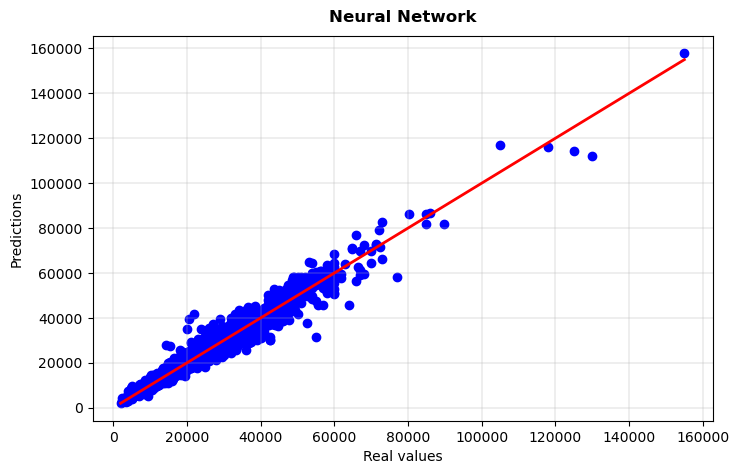

In [92]:
# Plot outputs
plt.figure(figsize = (8, 5))
plt.scatter(y_val, nn_pred, color="blue")
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linewidth=2)
plt.title("Neural Network", fontsize=12)
plt.xlabel("Real values", fontsize=10)
plt.ylabel("Predictions", fontsize=10)
plt.grid(linewidth=0.3)
plt.show()

## Conclusions

In [93]:
models = ["Linear Regression", "Decision Tree", "Random Forest", "KNN", "Neural Network"]
rmse_values = [lin_rmse, tree_rmse, rf_rmse, knn_rmse, nn_rmse]
mae_values = [lin_mae, tree_mae, rf_mae, knn_mae, nn_mae]

results_data = {
    "Model": models,
    "RMSE": rmse_values,
    "MAE": mae_values
}

results_df = pd.DataFrame(results_data)

print("Results\n")
for index, row in results_df.iterrows():
    print(f"{row['Model']:20} | RMSE: {row['RMSE']:.4f} | MAE: {row['MAE']:.4f}")

Results

Linear Regression    | RMSE: 4896.4090 | MAE: 3054.4360
Decision Tree        | RMSE: 3236.8323 | MAE: 1800.6005
Random Forest        | RMSE: 2453.3541 | MAE: 1448.4459
KNN                  | RMSE: 2665.2936 | MAE: 1615.8749
Neural Network       | RMSE: 2460.9972 | MAE: 1655.1395


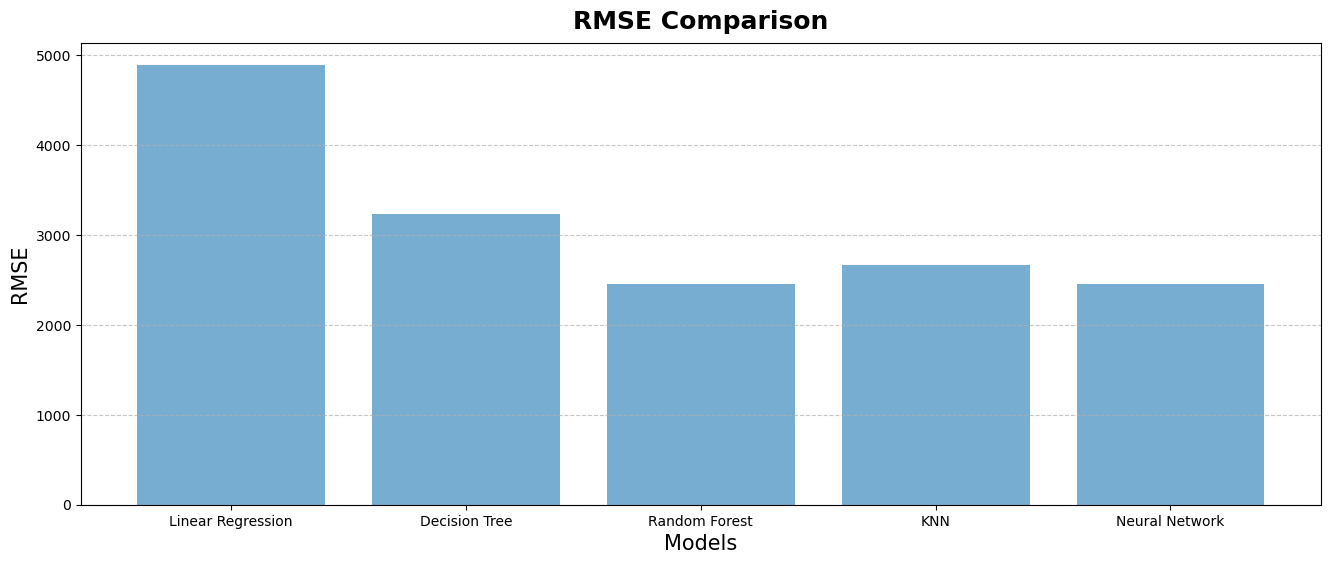

In [105]:
# RMSE plot
plt.figure(figsize=(16, 6))
bars = plt.bar(models, rmse_values, alpha = 0.6)
plt.xlabel('Models', fontsize = 15)
plt.ylabel('RMSE', fontsize = 15)
plt.title('RMSE Comparison', fontsize = 18)
plt.grid(axis = "y", linestyle = "--", alpha = 0.7)
plt.show() 

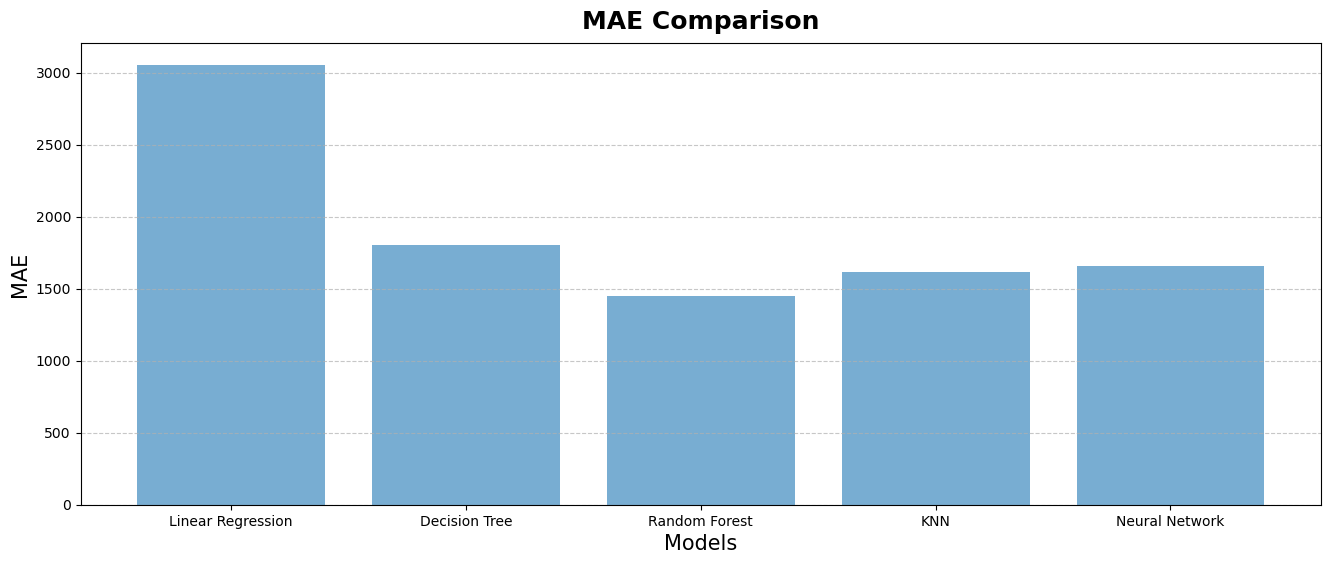

In [106]:
# MAE plot
plt.figure(figsize=(16, 6))
bars = plt.bar(models, mae_values, alpha = 0.6)
plt.xlabel('Models', fontsize = 15)
plt.ylabel('MAE', fontsize = 15)
plt.title('MAE Comparison', fontsize = 18)
plt.grid(axis = "y", linestyle = "--", alpha = 0.7)
plt.show() 

For both metrics, linear regression is the worst model, while random forest is the best. Instead, I notice that neural networks and knn behave differently according to the two metrics; the neural network has a lower value for rmse than knn, while it is the opposite with regard to mae.  
So I decide to evaluate the error on the test set for the three best models, Random Forest, Neural Network and KNN, to see if the performance confirms the same. 

In [98]:
print("Random Forest Test Set:")
rf_pred_test = rf_reg.predict(X_test)

# Root Mean Squared Error 
rf_mse_test = mean_squared_error(y_test, rf_pred_test)
rf_rmse_test = np.sqrt(rf_mse_test)
print("RMSE:",rf_rmse_test)
# Mean Absolute Error
rf_mae_test = mean_absolute_error(y_test, rf_pred_test)
print("MAE:",rf_mae_test)

Random Forest Test Set:
RMSE: 2483.7904526650154
MAE: 1465.0223639423343


In [99]:
print("KNN Test Set:")
knn_pred_test = knn_reg.predict(X_test)

# Root Mean Squared Error 
knn_mse_test = mean_squared_error(y_test, knn_pred_test)
knn_rmse_test = np.sqrt(knn_mse_test)
print("RMSE:",knn_rmse_test)
# Mean Absolute Error
knn_mae_test = mean_absolute_error(y_test, knn_pred_test)
print("MAE:",knn_mae_test)

KNN Test Set:
RMSE: 2668.8961357700555
MAE: 1622.5734688937303


In [100]:
print("Neaural Network Test Set:")
X_test_dense = X_test.toarray()
nn_pred_test = nn_reg.predict(X_test_dense)

# Root Mean Squared Error 
nn_mse_test = mean_squared_error(y_test, nn_pred_test)
nn_rmse_test = np.sqrt(nn_mse_test)
print("RMSE:",nn_rmse_test)
# Mean Absolute Error
nn_mae_test = mean_absolute_error(y_test, nn_pred_test)
print("MAE:",nn_mae_test)

Neaural Network Test Set:
259/259 [==============================] - 0s 482us/step
RMSE: 2526.0530677748407
MAE: 1642.7651250982826


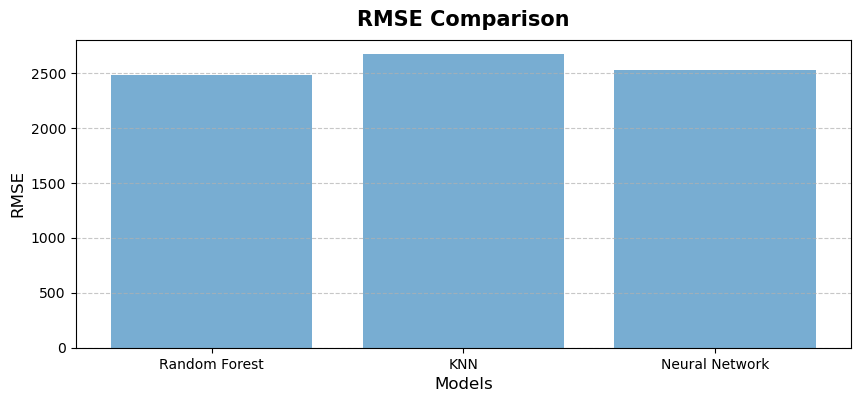

In [110]:
models_test = ["Random Forest", "KNN", "Neural Network"]
rmse_values_test = [rf_rmse_test, knn_rmse_test, nn_rmse_test]
mae_values_test = [rf_mae_test, knn_mae_test, nn_mae_test]

# RMSE plot
plt.figure(figsize=(10, 4))
bars = plt.bar(models_test, rmse_values_test, alpha = 0.6)
plt.xlabel('Models', fontsize = 12)
plt.ylabel('RMSE', fontsize = 12)
plt.title('RMSE Comparison', fontsize = 15)
plt.grid(axis = "y", linestyle = "--", alpha = 0.7)
plt.show() 

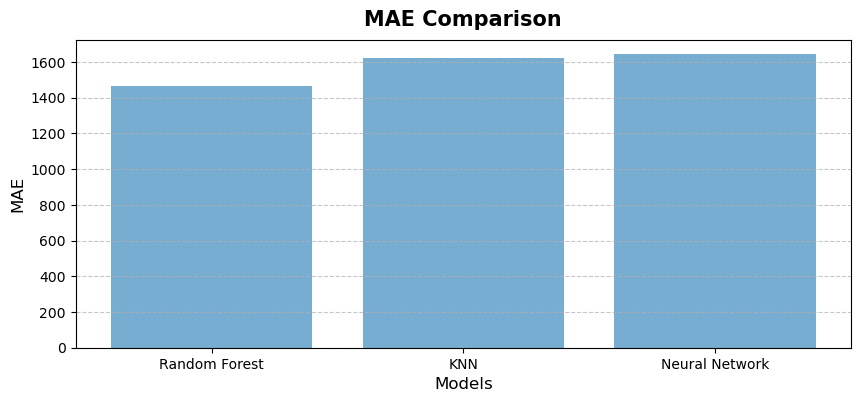

In [111]:
# MAE plot
plt.figure(figsize=(10, 4))
bars = plt.bar(models_test, mae_values_test, alpha = 0.6)
plt.xlabel('Models', fontsize = 12)
plt.ylabel('MAE', fontsize = 12)
plt.title('MAE Comparison', fontsize = 15)
plt.grid(axis = "y", linestyle = "--", alpha = 0.7)
plt.show() 

The final results are confirmed to be the same.